<a href="https://colab.research.google.com/github/myazann/Lung_Cancer/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf sample_data
!rm sample.py
!rm README.md
!pip install pydicom

import pandas as pd
import json
import os
import numpy as np
from pydicom import dcmread
import matplotlib.pyplot as plt
import cv2

In [ ]:
!cp ./drive/MyDrive/bboxs.json .
!cp ./drive/MyDrive/lung_ct_train.zip .
!cp ./drive/MyDrive/lung_ct_val.zip .


!unzip lung_ct_train.zip > /dev/null
!rm lung_ct_train.zip
!unzip lung_ct_val.zip > /dev/null
!rm lung_ct_val.zip


with open('bboxs.json') as json_file:
  labels = json.load(json_file)

Res Slope = 1, Res Int.  = -1024

In [ ]:
train_dcm_files = []
train_dcm_labels = []
val_dcm_files = []
val_dcm_labels = []


for ptnt in os.listdir("lung_ct_train"):
  for dcm in os.listdir("lung_ct_train/" + ptnt):
    try:
      file_name = "./lung_ct_train/" + ptnt + "/" + dcm
      dcm_file = dcmread(file_name)
      if dcm_file.SOPInstanceUID in labels.keys():

        pixel_array = dcm_file.pixel_array
        if len(pixel_array.shape) == 3:
          pixel_array = cv2.cvtColor(pixel_array, cv2.COLOR_RGB2GRAY) 

        train_dcm_files.append(pixel_array)
        train_dcm_labels.append(labels[dcm_file.SOPInstanceUID])


    except Exception as e:
      print(e)

for ptnt in os.listdir("lung_ct_val"):
  for dcm in os.listdir("lung_ct_val/" + ptnt):
    try:
      file_name = "./lung_ct_val/" + ptnt + "/" + dcm
      dcm_file = dcmread(file_name)
      if dcm_file.SOPInstanceUID in labels.keys():

        pixel_array = dcm_file.pixel_array
        if len(pixel_array.shape) == 3:
          pixel_array = cv2.cvtColor(pixel_array, cv2.COLOR_RGB2GRAY)

        val_dcm_files.append(dcm_file.pixel_array)
        val_dcm_labels.append(labels[dcm_file.SOPInstanceUID])


    except Exception as e:
      print(e)

In [ ]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
plt.hist(val_dcm_files[45].pixel_array.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

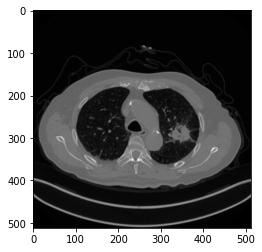

In [ ]:
plt.imshow(val_dcm_files[100], cmap=plt.cm.gray)
plt.show()